# Question and Answer Chat Bot

## Loading the Data
     
     We will be working with the Babi Data Set from Facebook Research.

In [1]:
import pandas as pd
import numpy as np
import keras
import pickle

Using TensorFlow backend.


In [2]:
with open('train_qa.txt','rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [4]:
type(train_data),type(test_data)

(list, list)

In [5]:
len(train_data),len(test_data)

(10000, 1000)

In [6]:
train_data[0] #each item is tuple of a story,question,answer 

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [7]:
test_data[0] #each item is tuple of a story,question,answer 

(['Mary',
  'got',
  'the',
  'milk',
  'there',
  '.',
  'John',
  'moved',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'John', 'in', 'the', 'kitchen', '?'],
 'no')

In [8]:
all_data = train_data+test_data

In [9]:
type(all_data),len(all_data)

(list, 11000)

## Creating Vocabulary

In [10]:
vocab = set()
for story,question,asnwer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
    
vocab.add('yes')
vocab.add('no')

len(vocab),vocab

(37,
 {'.',
  '?',
  'Daniel',
  'Is',
  'John',
  'Mary',
  'Sandra',
  'apple',
  'back',
  'bathroom',
  'bedroom',
  'discarded',
  'down',
  'dropped',
  'football',
  'garden',
  'got',
  'grabbed',
  'hallway',
  'in',
  'journeyed',
  'kitchen',
  'left',
  'milk',
  'moved',
  'no',
  'office',
  'picked',
  'put',
  'the',
  'there',
  'to',
  'took',
  'travelled',
  'up',
  'went',
  'yes'})

In [11]:
vocab_len = len(vocab) + 1
vocab_len

38

## Calculating lengths of all Stories and Questions in data and taking maximum value

In [12]:
max_story_length = max([len(data[0]) for data in all_data])
max_story_length

156

In [13]:
max_question_length = max([len(data[1]) for data in all_data])
max_question_length

6

In [14]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [15]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [16]:
tokenizer.word_index

{'back': 1,
 'travelled': 2,
 'milk': 3,
 'john': 4,
 'apple': 5,
 'discarded': 6,
 'garden': 7,
 'in': 8,
 'mary': 9,
 'there': 10,
 'got': 11,
 '?': 12,
 '.': 13,
 'went': 14,
 'moved': 15,
 'to': 16,
 'picked': 17,
 'bedroom': 18,
 'daniel': 19,
 'kitchen': 20,
 'put': 21,
 'left': 22,
 'up': 23,
 'football': 24,
 'took': 25,
 'office': 26,
 'journeyed': 27,
 'is': 28,
 'sandra': 29,
 'bathroom': 30,
 'the': 31,
 'dropped': 32,
 'down': 33,
 'yes': 34,
 'no': 35,
 'hallway': 36,
 'grabbed': 37}

In [17]:
# Methods for Fetching data from Tokenizer
tokenizer.index_word[35],tokenizer.word_index['bedroom']

('no', 18)

In [18]:
# train_story_text = [data[0] for data in train_data]
# train_question_text = [data[1] for data in train_data]
# train_answer_text = [data[2] for data in train_data]

## Function for Vectorizing data

In [19]:
def vectorize_data(data,word_index,max_story_len,max_ques_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    X = []
    Xq = []
    Y = []
    
    # iterating over all the data
    for story,question,answer in data:
        
        # conveting to sequence of numbers from text
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]
        
        # Creating a row with all zeroes
        y = np.zeros(len(word_index)+1)
        
        # Setting the value at index of yes/no = 1
        y[word_index[answer]] = 1
        
        # appending generated lists to our main list
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
    X = pad_sequences(X,maxlen=max_story_length)
    Xq = pad_sequences(Xq,maxlen=max_question_length)
    Y = np.array(Y)
    
    # Returning tuple for unpacking
    return (X,Xq,Y)

In [20]:
story_train,question_train,answer_train = vectorize_data(data=train_data,word_index=tokenizer.word_index,
                                                      max_story_len=max_story_length,max_ques_len=max_question_length)

In [21]:
story_test,question_test,answer_test = vectorize_data(data=test_data,word_index=tokenizer.word_index,
                                                      max_story_len=max_story_length,max_ques_len=max_question_length)

## Creating Model

### NOTE:
    We are going to use "End-to-End Memory Networks" architecture, so steps will be according to that.

In [22]:
from keras.models import Sequential,Model
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Dropout,Permute
from keras.layers import dot,concatenate,add

### Creating Place holders for our inputs

In [23]:
story_seq = Input(shape=(max_story_length,))
question_seq = Input(shape=(max_question_length,))

## Encoders

### Input Encoder : Memory Vector Representation (m)

In [24]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim=64))
input_encoder_m.add(Dropout(rate=0.3))
# output: (samples, story_maxlen, embedding_dim)

Instructions for updating:
Colocations handled automatically by placer.


### Input Encoder : Output Vector Representation (c)

In [25]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim=max_question_length))
input_encoder_c.add(Dropout(rate=0.3))
# output: (samples, story_maxlen, ques_maxlen)

### Question Encoder (u)

In [26]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,output_dim=64,input_length=max_question_length))
question_encoder.add(Dropout(rate=0.3))
# output: (samples, ques_maxlen, embedding_dim)

### Encoding the sequences

In [27]:
input_encoded_m = input_encoder_m(story_seq)
input_encoded_c = input_encoder_c(story_seq)
question_encoded = question_encoder(question_seq)

### Compute the dot product between input memory embedding and question embedding

In [28]:
match = dot([input_encoded_m,question_encoded],axes=(2,2))
match = Activation(activation='softmax')(match)

### Compute the weighted sum of output memory embeddding and computed match matrix

In [29]:
response = add([match,input_encoded_c]) # (samples, story_maxlen, ques_maxlen)
response = Permute(dims=(2,1))(response) # (samples, ques_maxlen, story_maxlen)

### Concatenate the Output and Question embedding

In [30]:
answer = concatenate([response,question_encoded])
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [31]:
# Reduce with RNN(LSTM)
answer = LSTM(32)(answer)
answer

<tf.Tensor 'lstm_1/strided_slice_18:0' shape=(?, 32) dtype=float32>

In [32]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(units=vocab_len)(answer)
answer

<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 38) dtype=float32>

In [33]:
answer = Activation(activation='softmax')(answer)
answer

<tf.Tensor 'activation_2/Softmax:0' shape=(?, 38) dtype=float32>

In [34]:
# Building the model
model = Model([story_seq,question_seq],answer)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

In [35]:
# Training the Model
history = model.fit([story_train,question_train],answer_train,epochs=120,batch_size = 32,validation_data=([story_test,question_test],answer_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 8s 790us/step - loss: 0.9063 - accuracy: 0.4963 - val_loss: 0.7004 - val_accuracy: 0.5030
Epoch 2/120
10000/10000 [==============================] - 6s 614us/step - loss: 0.7036 - accuracy: 0.4974 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 3/120
10000/10000 [==============================] - 6s 606us/step - loss: 0.6967 - accuracy: 0.4979 - val_loss: 0.6944 - val_accuracy: 0.4970
Epoch 4/120
10000/10000 [==============================] - 6s 609us/step - loss: 0.6952 - accuracy: 0.4977 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 5/120
10000/10000 [==============================] - 7s 668us/step - loss: 0.6952 - accuracy: 0.4998 - val_loss: 0.6940 - val_accuracy: 0.4970
Epoch 6/120
10000/10000 [==============================] - 6s 585us/step - loss:

10000/10000 [==============================] - 6s 596us/step - loss: 0.2818 - accuracy: 0.8725 - val_loss: 0.3411 - val_accuracy: 0.8400
Epoch 52/120
10000/10000 [==============================] - 6s 573us/step - loss: 0.2887 - accuracy: 0.8664 - val_loss: 0.3401 - val_accuracy: 0.8390
Epoch 53/120
10000/10000 [==============================] - 6s 604us/step - loss: 0.2831 - accuracy: 0.8719 - val_loss: 0.3448 - val_accuracy: 0.8400
Epoch 54/120
10000/10000 [==============================] - 6s 587us/step - loss: 0.2856 - accuracy: 0.8725 - val_loss: 0.3567 - val_accuracy: 0.8400
Epoch 55/120
10000/10000 [==============================] - 6s 596us/step - loss: 0.2828 - accuracy: 0.8722 - val_loss: 0.3445 - val_accuracy: 0.8420
Epoch 56/120
10000/10000 [==============================] - 6s 582us/step - loss: 0.2787 - accuracy: 0.8698 - val_loss: 0.3612 - val_accuracy: 0.8360
Epoch 57/120
10000/10000 [==============================] - 6s 640us/step - loss: 0.2821 - accuracy: 0.8752 - val

10000/10000 [==============================] - 6s 576us/step - loss: 0.1985 - accuracy: 0.9158 - val_loss: 0.4090 - val_accuracy: 0.8490
Epoch 106/120
10000/10000 [==============================] - 6s 572us/step - loss: 0.1914 - accuracy: 0.9178 - val_loss: 0.4058 - val_accuracy: 0.8610
Epoch 107/120
10000/10000 [==============================] - 6s 583us/step - loss: 0.1821 - accuracy: 0.9225 - val_loss: 0.4282 - val_accuracy: 0.8620
Epoch 108/120
10000/10000 [==============================] - 6s 578us/step - loss: 0.1754 - accuracy: 0.9284 - val_loss: 0.4434 - val_accuracy: 0.8600
Epoch 109/120
10000/10000 [==============================] - 6s 576us/step - loss: 0.1781 - accuracy: 0.9260 - val_loss: 0.4216 - val_accuracy: 0.8660
Epoch 110/120
10000/10000 [==============================] - 6s 576us/step - loss: 0.1809 - accuracy: 0.9241 - val_loss: 0.3950 - val_accuracy: 0.8680
Epoch 111/120
10000/10000 [==============================] - 6s 585us/step - loss: 0.1662 - accuracy: 0.9348

### Saving the Model

In [36]:
file ='sachin_chatbot_120.h5'
model.save(file)

In [37]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


## Evaluating the model performance

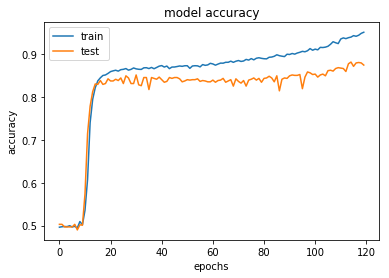

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper left')
plt.show()


## Testing our model on given Test Set

In [39]:
model.load_weights('sachin_chatbot_120.h5')
predict_results = model.predict(([story_test,question_test]))
print(predict_results.shape)

(1000, 38)


In [40]:
print(predict_results[0])
print('-'*100)
print(np.argmax(predict_results[0]))

[1.8857692e-20 1.5202489e-20 2.0125127e-20 2.1908042e-20 1.8064080e-20
 1.6890261e-20 2.2058485e-20 1.4988909e-20 1.9828918e-20 2.2033340e-20
 2.2154283e-20 2.1789690e-20 1.5331487e-20 1.8313654e-20 1.6595704e-20
 2.1956735e-20 1.6579504e-20 1.9694959e-20 1.4946713e-20 2.2446577e-20
 1.7015916e-20 1.6108073e-20 1.9271265e-20 2.0889335e-20 1.7490484e-20
 1.9025543e-20 1.7298587e-20 1.8062634e-20 1.8110515e-20 1.9898403e-20
 2.0306195e-20 1.6983687e-20 1.7130935e-20 2.0199502e-20 1.8519891e-08
 1.0000000e+00 2.0071000e-20 2.4801873e-20]
----------------------------------------------------------------------------------------------------
35


In [41]:
final_answers_idx = np.argmax(predict_results,axis=1)
final_answers_idx.shape

(1000,)

In [42]:
final_answers_idx[:10]

array([35, 35, 35, 34, 34, 35, 35, 34, 35, 34])

In [43]:
#Generate actual prediction from model
words_dict = tokenizer.index_word
final_answer_value = [words_dict.get(i) for i in final_answers_idx]
final_answer_value[:10]

['no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes']

# We are done with our work!!

## Now Testing on custom generated data

In [44]:
custom_story = 'Sandra moved to kitchen . Sandra picked football . Sandra went back to the garden .'

In [45]:
custom_question = 'Is Sandra in the kitchen ?'

In [46]:
custom_data = [(custom_story.split(),custom_question.split(),'no')]

In [47]:
custom_story_vec,custom_question_vec,custom_answer = vectorize_data(custom_data,tokenizer.word_index,max_story_length,max_question_length)

In [48]:
custom_story_vec,custom_question_vec,custom_answer

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 29, 15, 16, 20,
         13, 29, 17, 24, 13, 29, 14,  1, 16, 31,  7, 13]], dtype=int32),
 array([[28, 29,  8, 31, 20, 12]], dtype=int32),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0.]]))

In [49]:
custom_pred = model.predict(([custom_story_vec,custom_question_vec]))
custom_pred

array([[1.30988997e-13, 1.08587889e-13, 1.18585439e-13, 1.24269356e-13,
        1.18627059e-13, 1.29886119e-13, 1.36877367e-13, 1.09185196e-13,
        1.19692762e-13, 1.15861829e-13, 1.07033956e-13, 1.15823610e-13,
        1.13956831e-13, 1.18843791e-13, 1.30621249e-13, 1.19475393e-13,
        1.23713594e-13, 1.27218264e-13, 1.15581955e-13, 1.50375684e-13,
        1.25063534e-13, 1.28208696e-13, 1.21747285e-13, 1.09218732e-13,
        1.13798267e-13, 1.15169118e-13, 1.08866197e-13, 1.28032513e-13,
        1.08888213e-13, 1.20155947e-13, 1.10035455e-13, 1.08875331e-13,
        1.20239634e-13, 1.18248659e-13, 5.73500022e-02, 9.42649961e-01,
        1.16080810e-13, 1.12939816e-13]], dtype=float32)

In [50]:
val_max = np.argmax(custom_pred[0])
val_max

35

In [51]:
print("Predicted answer is: ", tokenizer.index_word[val_max])

Predicted answer is:  no


In [52]:
print("Probability of certainty was: {:.2f} %".format(custom_pred[0][val_max]*100))

Probability of certainty was: 94.26 %


## Great Job!!!